# Family Income and Expenditure

### Predicting income class based on location and spending habits

We first need to import the necessary packages.

In [116]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

file_path = '..\\datasets\\'
raw_fies = pd.read_csv(file_path + 'family_income_and_expenditure.csv')
raw_fies.head()

,Total Household Income,Region,Total Food Expenditure,Main Source of Income,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,...,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
0,480332,CAR,117848,Wage/Salaries,0,42140,38300,24676,16806,3325,...,1,1,0,0,0,2,1,0,0,1
1,198235,CAR,67766,Wage/Salaries,0,17329,13008,17434,11073,2035,...,0,1,0,0,0,3,1,0,0,2
2,82785,CAR,61609,Wage/Salaries,1,34182,32001,7783,2590,1730,...,0,0,0,0,0,0,0,0,0,0
3,107589,CAR,78189,Wage/Salaries,0,34030,28659,10914,10812,690,...,0,0,0,0,0,1,0,0,0,0
4,189322,CAR,94625,Wage/Salaries,0,34820,30167,18391,11309,1395,...,1,0,0,0,0,3,0,0,0,1


In [117]:
raw_fies.shape

(41544, 60)

Let's see what the Lorenz curve of the country looks like

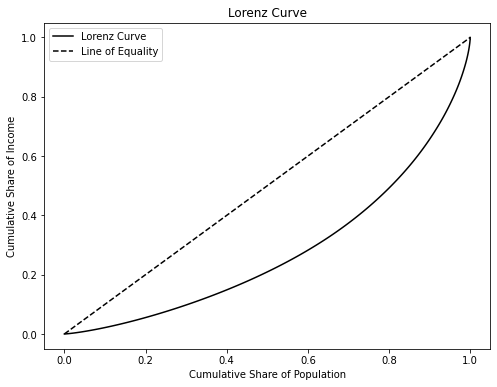

The Gini coefficient for this curve is 0.443841419057589


In [118]:
income = raw_fies['Total Household Income'].values
income_sorted = np.sort(income)
cumulative_income = np.cumsum(income_sorted)
lorenz_curve = cumulative_income / cumulative_income[-1]
lorenz_curve = np.insert(lorenz_curve, 0, 0)
x_values = np.linspace(0, 1, len(lorenz_curve))

plt.figure(figsize=(8, 6))
plt.plot(x_values, lorenz_curve, 'k', drawstyle='steps-post', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Line of Equality')
plt.xlabel('Cumulative Share of Population')
plt.ylabel('Cumulative Share of Income')
plt.title('Lorenz Curve')
plt.legend()
plt.show()

gini_coefficient = 1 - 2 *  np.trapz(lorenz_curve, x_values) 
print('The Gini coefficient for this curve is {}'.format(gini_coefficient))

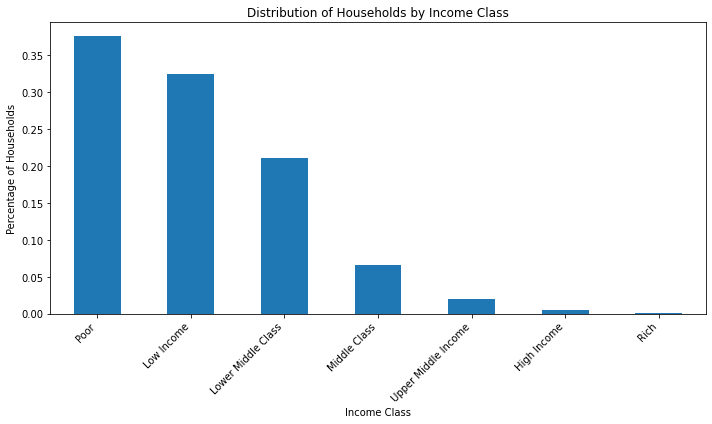

In [119]:
income_bins = [-float('inf'), 10957, 21194, 43828, 76669, 131484, 219140, float('inf')]
income_labels = ['Poor', 'Low Income', 'Lower Middle Class', 'Middle Class', 'Upper Middle Income', 'High Income', 'Rich']

raw_fies['Income Class'] = pd.cut(raw_fies['Total Household Income']/12, bins=income_bins, labels=income_labels, right=False)

raw_fies.drop(columns=['Total Household Income'], inplace=True)


plt.figure(figsize=(10, 6))
raw_fies['Income Class'].value_counts(sort=False, normalize= True).plot(kind='bar')
plt.xlabel('Income Class')
plt.ylabel('Percentage of Households')
plt.title('Distribution of Households by Income Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [120]:
target_col = 'Income Class'
exp_cols = [col for col in raw_fies.columns if 'Expenditure' in col or 'expense' in col]
# tent_feat_cols = [col for col in raw_fies.columns if col not in target_col]
tent_feat_cols = exp_cols
fies = raw_fies[tent_feat_cols]

Get the numerical columns and categorical columns with low cardinality (unique values is less than 20).

In [121]:
num_cols = [col for col in fies.columns if fies[col].dtype in ['int64','flt64']]
cat_cols = [col for col in fies.columns if fies[col].dtype in ['object', 'category'] and fies[col].nunique() < 20]
total_cols = num_cols + cat_cols

Are there null columns?

In [122]:
null = [col for col in total_cols if fies[col].isnull().any()]
print(null)

[]


In [123]:
target_fies = raw_fies[target_col]
feat_fies = raw_fies[total_cols]

x_train, x_test, y_train, y_test = train_test_split(feat_fies, target_fies, train_size = 0.8, random_state = 0)

In [124]:
num_transformer = SimpleImputer(strategy = 'median')
cat_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy= 'constant')),('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocess = ColumnTransformer(transformers = [('num', num_transformer, num_cols), ('cat', cat_transformer, cat_cols)])

In [130]:
forest_model = RandomForestClassifier(random_state=0)


max_leaf_nodes = [node_val for node_val in range(300, 900, 1)]
max_depth = [depth for depth in range(1, 100, 1)]

random_grid = {'max_leaf_nodes': max_leaf_nodes, 'max_depth': max_depth}
n_estimators = [estim for estim in range(1, 100, 1)]

model_random = RandomizedSearchCV(
    estimator=forest_model,
    param_distributions={**random_grid, 'n_estimators': n_estimators},
    n_iter=20, cv=3, verbose=3, random_state=0, n_jobs=-1
)

pipeline = Pipeline(steps = [('preprocessor', preprocess), ('model', model_random)])
pipeline.fit(x_train, y_train.values.ravel())

opt_estim = model_random.best_params_['n_estimators']
opt_nodes = model_random.best_params_['max_leaf_nodes']
opt_depth = model_random.best_params_['max_depth']

print('The optimal n_estimator is: {}'.format(opt_estim))
print('The optimal max_leaf_nodes is: {}'.format(opt_nodes))
print('The optimal max_depth is: {}'.format(opt_depth))
print('The best score for the training data given the optimum parameters is {:.2f}%'.format(100 * model_random.best_score_))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
The optimal n_estimator is: 99
The optimal max_leaf_nodes is: 893
The optimal max_depth is: 25
The best score for the training data given the optimum parameters is 74.94%
